
# Modular Quantitative Research Workflow in Algorithmic Trading  
## End-to-End Example on MSFT (Triple-Barrier + Random Forest + vectorbt)

This notebook demonstrates a **modular research framework** for systematic / algorithmic trading.

We will walk through a practical pipeline on the S&P 500 ETF (**MSFT**):

1. **Data Curation**  
2. **Data Labeling** (simplified *triple-barrier* à la López de Prado)  
3. **Predictive Modelling** (Random Forest classifier)  
4. **Strategy Construction** (mapping predictions to positions)  
5. **Backtesting & Evaluation** using `vectorbt`

The focus is on the **structure of the workflow**, not on building a production-ready strategy.  
The example will likely look reasonably profitable (and a bit overfit), which is fine for teaching.


In [81]:

import numpy as np
import pandas as pd

import yfinance as yf

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt

import vectorbt as vbt

plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option("display.max_columns", 50)



## 1. Data Curation

In a real quant research environment, **data curation** is a major part of the job:

- Collecting raw market data (trades, quotes, OHLCV, fundamentals, etc.)
- Cleaning outliers and bad ticks
- Adjusting for corporate actions (splits, dividends)
- Ensuring there is **no look-ahead** and **no survivorship bias**

For this didactic example, we will:

- Use `yfinance` to download **daily OHLCV data** for MSFT.
- Use **adjusted prices** via `auto_adjust=True`, so dividends and splits are handled.
- Keep cleaning minimal (dropping obvious missing values).


In [82]:
ticker = "MSFT"
start_date = "2020-01-01"

# Download data
raw = yf.download(ticker, start=start_date, auto_adjust=True)

# If yfinance returns a MultiIndex (e.g., ('Close', 'MSFT')), flatten it to just 'Close'
if isinstance(raw.columns, pd.MultiIndex):
    raw.columns = raw.columns.get_level_values(0)

# Basic cleaning: drop missing rows
raw = raw.dropna()

# Rename columns to lower case for convenience
data = raw.rename(
    columns={
        "Open": "open",
        "High": "high",
        "Low": "low",
        "Close": "close",
        "Volume": "volume",
    }
)

data.head()

[*********************100%***********************]  1 of 1 completed


Price,close,high,low,open,volume
Date,,,,,
2020-01-02,152.791107,152.895746,150.612732,151.040795,22622100
2020-01-03,150.888596,152.153771,150.355893,150.603230,21116200
2020-01-06,151.278610,151.345205,148.881435,149.423659,20813700
2020-01-07,149.899323,151.887449,149.652001,151.554518,21634100
2020-01-08,152.286926,152.962326,150.251234,151.183463,27746500



## 2. Data Labeling — Simplified Triple-Barrier Method

We now transform raw prices into **labels** for supervised learning.

Inspired by **López de Prado's triple-barrier method**, we:

1. Estimate **daily volatility** from log returns.
2. For each day:
   - Set an **upper barrier** (profit-taking level)
   - Set a **lower barrier** (stop-loss level)
   - Set a **time barrier** (maximum holding period in days)
3. Look forward in time:
   - If the **upper barrier** is hit first → label = **+1**
   - If the **lower barrier** is hit first → label = **−1**
   - If neither is hit before the time barrier → label = **0**

This gives us labels that encode a directional view and basic risk boundaries.


In [83]:

def get_daily_vol(close: pd.Series, span: int = 50) -> pd.Series:
    """Estimate daily volatility using exponentially weighted moving std of log returns."""
    log_ret = np.log(close / close.shift(1))
    vol = log_ret.ewm(span=span).std()
    return vol


def apply_triple_barrier(
    close: pd.Series,
    daily_vol: pd.Series,
    pt_mult: float = 1.0,
    sl_mult: float = 1.0,
    max_holding: int = 10,
) -> pd.Series:
    """Simplified triple-barrier labeling.

    Parameters
    ----------
    close : pd.Series
        Close prices.
    daily_vol : pd.Series
        Daily volatility estimate (same index as `close`).
    pt_mult : float
        Profit-take barrier multiple of volatility.
    sl_mult : float
        Stop-loss barrier multiple of volatility.
    max_holding : int
        Maximum holding period in days (time barrier).

    Returns
    -------
    labels : pd.Series
        +1 if upper barrier hit first,
        -1 if lower barrier hit first,
         0 if neither barrier is hit before the time limit,
         NaN for points where we cannot look far enough ahead.
    """
    close = close.copy()
    daily_vol = daily_vol.copy()
    labels = pd.Series(index=close.index, dtype="float64")

    n = len(close)
    for i in range(n):
        if i + 1 >= n:
            labels.iloc[i] = np.nan
            continue

        price_t = close.iloc[i]
        vol_t = daily_vol.iloc[i]

        if np.isnan(vol_t):
            labels.iloc[i] = np.nan
            continue

        # Barriers
        pt = price_t * (1 + pt_mult * vol_t)
        sl = price_t * (1 - sl_mult * vol_t)

        # Look forward up to max_holding steps, but stay inside the series
        end_idx = min(i + 1 + max_holding, n)
        future_prices = close.iloc[i + 1 : end_idx]

        hit_pt = (future_prices >= pt)
        hit_sl = (future_prices <= sl)

        hit_pt_idx = hit_pt.idxmax() if hit_pt.any() else None
        hit_sl_idx = hit_sl.idxmax() if hit_sl.any() else None

        # Decide which barrier hit first
        if hit_pt_idx is not None and hit_sl_idx is not None:
            if hit_pt_idx < hit_sl_idx:
                labels.iloc[i] = 1
            elif hit_sl_idx < hit_pt_idx:
                labels.iloc[i] = -1
            else:
                labels.iloc[i] = 0
        elif hit_pt_idx is not None:
            labels.iloc[i] = 1
        elif hit_sl_idx is not None:
            labels.iloc[i] = -1
        else:
            labels.iloc[i] = 0

    # Last few points where we don't have max_holding lookahead are already NaN
    return labels


In [84]:

# Use 'close' as the adjusted price series
data["adj_close"] = data["close"]

# 1. Daily volatility
data["daily_vol"] = get_daily_vol(data["adj_close"], span=50)

# 2. Triple-barrier labels
data["label"] = apply_triple_barrier(
    close=data["adj_close"],
    daily_vol=data["daily_vol"],
    pt_mult=1.0,
    sl_mult=1.0,
    max_holding=10,
)

# Drop rows where label is NaN
data = data.dropna(subset=["label"])

data[["adj_close", "daily_vol", "label"]].head(15)


Price,adj_close,daily_vol,label
Date,,,
2020-01-06,151.278610,0.010685,1.0
2020-01-07,149.899323,0.007895,1.0
2020-01-08,152.286926,0.012963,1.0
2020-01-09,154.189453,0.012595,1.0
2020-01-10,153.476028,0.011535,1.0
2020-01-13,155.321472,0.011284,1.0
2020-01-14,154.227539,0.010979,1.0
2020-01-15,155.226349,0.010322,1.0
2020-01-16,158.070618,0.011091,-1.0



## 3. Feature Engineering & Predictive Model

We now build a **predictive model** that tries to forecast the triple-barrier label (+1 / 0 / −1).

Features (simple technical indicators):

- **Past returns** over 1, 5, and 10 days
- **Moving averages** (10-day and 20-day) combined into a ratio
- **Daily volatility** (from the previous step)

Workflow:

1. Build a feature matrix `X` and label vector `y`.
2. Split into **train** and **test** by date (no shuffling).
3. Train a **Random Forest classifier** on the training period.
4. Check classification metrics on the test period.


In [85]:

# Feature engineering
data["ret_1d"] = data["adj_close"].pct_change(1)
data["ret_5d"] = data["adj_close"].pct_change(5)
data["ret_10d"] = data["adj_close"].pct_change(10)

data["ma_10"] = data["adj_close"].rolling(10).mean()
data["ma_20"] = data["adj_close"].rolling(20).mean()
data["ma_ratio_10_20"] = data["ma_10"] / data["ma_20"]

feature_cols = ["ret_1d", "ret_5d", "ret_10d", "daily_vol", "ma_ratio_10_20"]

# Drop rows with NaNs in features or labels
data = data.dropna(subset=feature_cols + ["label"])

X = data[feature_cols]
y = data["label"].astype(int)

# Time-based train/test split
split_date = "2022-01-01"
train_mask = X.index < split_date
test_mask = X.index >= split_date

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

X_train.shape, X_test.shape


((484, 5), (974, 5))

In [86]:

rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_leaf=20,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

print("Classification report (test period):")
print(classification_report(y_test, y_pred))

print("Confusion matrix (test period):")
print(confusion_matrix(y_test, y_pred))


Classification report (test period):
              precision    recall  f1-score   support

          -1       0.40      0.13      0.20       430
           0       0.00      0.00      0.00        26
           1       0.53      0.86      0.66       518

    accuracy                           0.51       974
   macro avg       0.31      0.33      0.29       974
weighted avg       0.46      0.51      0.44       974

Confusion matrix (test period):
[[ 57   0 373]
 [ 10   0  16]
 [ 74   0 444]]


c:\Users\boleb\OneDrive\Desktop\Quantitative\Quant Projects\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\boleb\OneDrive\Desktop\Quantitative\Quant Projects\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\boleb\OneDrive\Desktop\Quantitative\Quant Projects\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




## 4. Strategy Construction — From Predictions to Positions

We now turn model predictions into a **trading strategy**.

Steps:

1. Use the model to estimate **class probabilities** for each day:
   \( P(y=-1), P(y=0), P(y=1) \).
2. Compute a **directional score**:
   \[ s_t = P(y=1) - P(y=-1) \]
3. Map this score into a **position**:
   - If \( s_t > \theta \) → go **long** (position = +1)
   - If \( s_t < -\theta \) → go **short** (position = −1)
   - Else → **flat** (position = 0)
4. Shift positions by one day so today’s decision only affects **tomorrow’s** trade (no look-ahead).


In [87]:

# Predict class probabilities on the entire dataset
proba = rf_clf.predict_proba(X)
classes = rf_clf.classes_

# Map to score = P(+1) - P(-1)
idx_neg1 = np.where(classes == -1)[0][0]
idx_pos1 = np.where(classes == 1)[0][0]

score = proba[:, idx_pos1] - proba[:, idx_neg1]
data["score"] = pd.Series(score, index=X.index)

# Position rule
threshold = 0.05
data["raw_position"] = 0
data.loc[data["score"] > threshold, "raw_position"] = 1
data.loc[data["score"] < -threshold, "raw_position"] = -1

# Shift to avoid look-ahead: today's signal → tomorrow's position
data["position"] = data["raw_position"].shift(1).fillna(0)

data[["adj_close", "score", "raw_position", "position"]].head(20)


Price,adj_close,score,raw_position,position
Date,,,,
2020-02-03,165.880386,0.050521,1,0.0
2020-02-04,171.340622,0.160308,1,1.0
2020-02-05,171.131393,0.183064,1,1.0
2020-02-06,174.679626,0.186551,1,1.0
2020-02-07,174.926895,0.137342,1,1.0
2020-02-10,179.502457,0.048651,0,1.0
2020-02-11,175.450104,0.212599,1,0.0
2020-02-12,175.706970,0.112562,1,1.0
2020-02-13,174.755661,-0.120525,-1,1.0



## 5. Backtesting with `vectorbt`

We will now evaluate the strategy on the **test period** only, using `vectorbt`:

1. Restrict `price` and `position` to the test index.
2. Turn the **desired position series** into long/short entries and exits.
3. Use `vectorbt.Portfolio.from_signals` to simulate trading with:
   - Long and short positions
   - Transaction fees and slippage
4. Compare the results to a **buy & hold MSFT** benchmark on the same period.


In [88]:

# Restrict to test period
test_index = X_test.index

price_test = data.loc[test_index, "adj_close"]
position_test = data.loc[test_index, "position"].fillna(0).astype(int)

# Build entry/exit signals from position changes
pos = position_test

long_entries  = (pos == 1) & (pos.shift(1).fillna(0) != 1)
long_exits    = (pos != 1) & (pos.shift(1).fillna(0) == 1)

short_entries = (pos == -1) & (pos.shift(1).fillna(0) != -1)
short_exits   = (pos != -1) & (pos.shift(1).fillna(0) == -1)

# Strategy portfolio
pf = vbt.Portfolio.from_signals(
    close=price_test,
    entries=long_entries,
    exits=long_exits,
    short_entries=short_entries,
    short_exits=short_exits,
    init_cash=100_000,
    fees=0.0005,     # 5 bps per trade
    slippage=0.0005, # 5 bps slippage
    direction="both",
)

# Buy & hold benchmark
bh_pf = vbt.Portfolio.from_holding(
    close=price_test,
    init_cash=100_000,
)

pf_stats = pf.stats()
bh_stats = bh_pf.stats()

print("=== Strategy stats (test period) ===")
display(pf_stats)

print("\n=== Buy & Hold MSFT stats (test period) ===")
display(bh_stats[pf_stats.index])


=== Strategy stats (test period) ===


C:\Users\boleb\AppData\Local\Temp\ipykernel_14156\3049051682.py:17: UserWarning:

direction has no effect if short_entries and short_exits are set

c:\Users\boleb\OneDrive\Desktop\Quantitative\Quant Projects\.venv\Lib\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

c:\Users\boleb\OneDrive\Desktop\Quantitative\Quant Projects\.venv\Lib\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

c:\Users\boleb\OneDrive\Desktop\Quantitative\Quant Projects\.venv\Lib\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

c:\Users\boleb\OneDrive\Desktop\Quantitative\Quant Projects\.venv\Lib\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set

c:\Users\boleb\OneDrive\Desktop\Quantitative\Quant Projects\.venv\Lib\site-packages\vectorbt\gen

Start                         2022-01-03 00:00:00
End                           2025-11-18 00:00:00
Period                                        974
Start Value                              100000.0
End Value                           186399.560803
Total Return [%]                        86.399561
Benchmark Return [%]                    52.167348
Max Gross Exposure [%]                      100.0
Total Fees Paid                      13882.412209
Max Drawdown [%]                        19.622801
Max Drawdown Duration                       160.0
Total Trades                                   97
Total Closed Trades                            96
Total Open Trades                               1
Open Trade PnL                       -4343.019829
Win Rate [%]                            55.208333
Best Trade [%]                          21.003236
Worst Trade [%]                        -10.294127
Avg Winning Trade [%]                    3.084392
Avg Losing Trade [%]                    -2.115869



=== Buy & Hold MSFT stats (test period) ===


Start                         2022-01-03 00:00:00
End                           2025-11-18 00:00:00
Period                                        974
Start Value                              100000.0
End Value                           152167.347574
Total Return [%]                        52.167348
Benchmark Return [%]                    52.167348
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        35.578837
Max Drawdown Duration                       350.0
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                       52167.347574
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


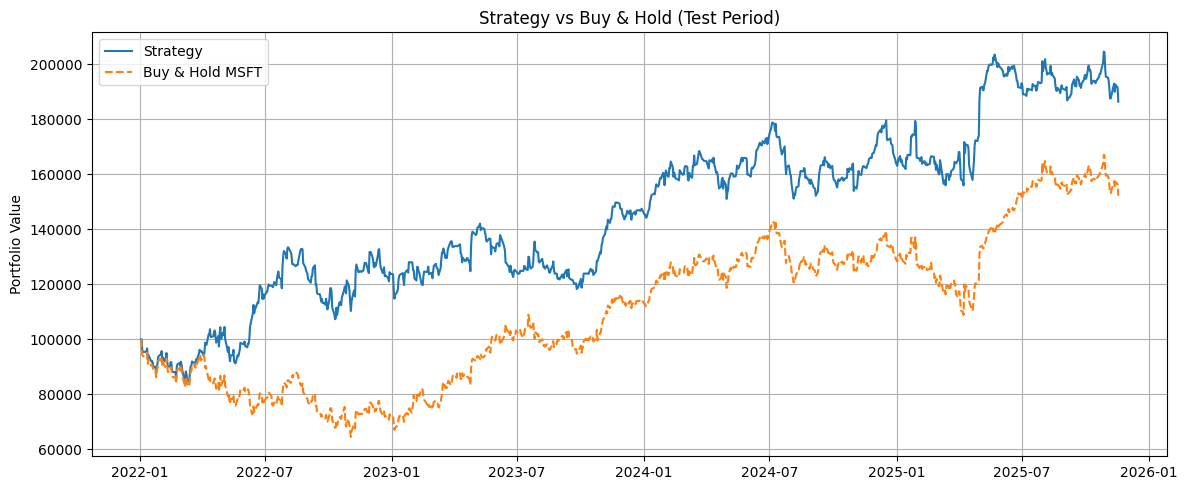

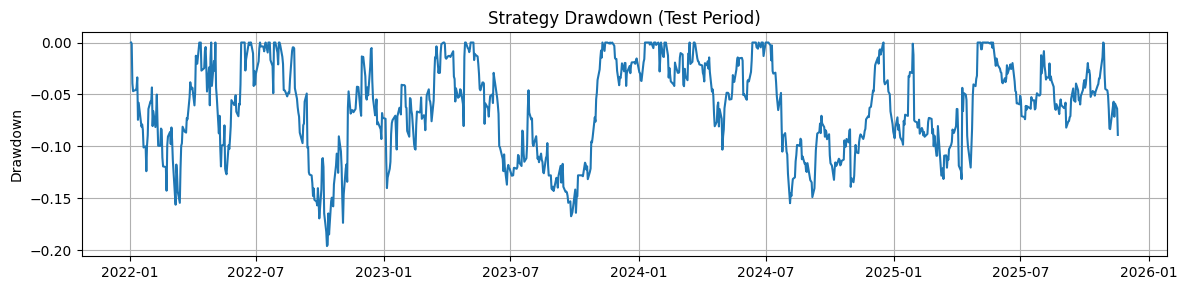

In [89]:

# Equity curves
strat_equity = pf.value()
bh_equity = bh_pf.value()

plt.figure(figsize=(12, 5))
plt.plot(strat_equity.index, strat_equity, label="Strategy")
plt.plot(bh_equity.index, bh_equity, label="Buy & Hold MSFT", linestyle="--")
plt.title("Strategy vs Buy & Hold (Test Period)")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Drawdown for strategy
running_max = strat_equity.cummax()
dd = strat_equity / running_max - 1.0

plt.figure(figsize=(12, 3))
plt.plot(dd.index, dd)
plt.title("Strategy Drawdown (Test Period)")
plt.ylabel("Drawdown")
plt.grid(True)
plt.tight_layout()
plt.show()



## 6. Recap & Possible Extensions

We implemented a full **modular quant research workflow** on MSFT:

1. **Data Curation**  
   - Downloaded and lightly cleaned daily OHLCV data for MSFT.

2. **Data Labeling (Triple-Barrier)**  
   - Estimated daily volatility.
   - Applied a simplified triple-barrier scheme to get labels (+1, 0, −1).

3. **Predictive Modelling**  
   - Engineered simple technical features (returns, moving-average ratio, volatility).
   - Trained a `RandomForestClassifier` with a time-based train/test split.

4. **Strategy Construction**  
   - Converted class probabilities into a directional score.
   - Mapped the score into long/short/flat positions with a confidence threshold.
   - Shifted positions to avoid look-ahead bias.

5. **Backtesting with `vectorbt`**  
   - Built a long/short portfolio from signals.
   - Compared performance against a buy & hold MSFT benchmark.
   - Visualized equity curves and drawdowns.

---

### Next Steps

- Extend from 1 asset (MSFT) to a **cross-sectional universe** of stocks or ETFs.
- Experiment with different **labeling schemes** (e.g. pure time-horizon returns, meta-labeling).
- Try richer **feature sets** and different model classes (gradient boosting, etc.).
- Add **transaction cost modelling** and realistic constraints.
- Use more advanced `vectorbt` or other backtesting tools for multi-asset portfolios.

This notebook is intended as a **teaching template** for a modular quant research framework.  
You can duplicate it and swap individual modules (labeling, model, strategy, backtest) while keeping the structure.
